# Burger's Equation

$$
\int_{\Omega} \frac{\partial u}{\partial t} + (u . \nabla) u - \nu \nabla^2 u dx = 0
$$

$$
\equiv \int_{\Omega} \frac{\partial u}{\partial t} . v + ((u . \nabla) u).v + \nu (\nabla u. \nabla v) dx = 0
$$


In [4]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
%matplotlib inline


NU = 0.0001


def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        dt = Constant(P.timesteps[index])
        nu = Constant(NU)

        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(dot(u, nabla_grad(u)), v) * dx
            + nu * inner(grad(u), grad(v)) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)

        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])

        # Define form
        F = mesh_seq.form(index, {"u": (u, u_)})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": VectorFunctionSpace(mesh, "CG", 2)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(mesh_seq[0])
    # An initial condition that propagates to both ends
    return {"u": interpolate(as_vector([sin(pi * (x - 0.5)), 0]), fs)}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        return inner(u, u) * ds(2)

    return end_time_qoi


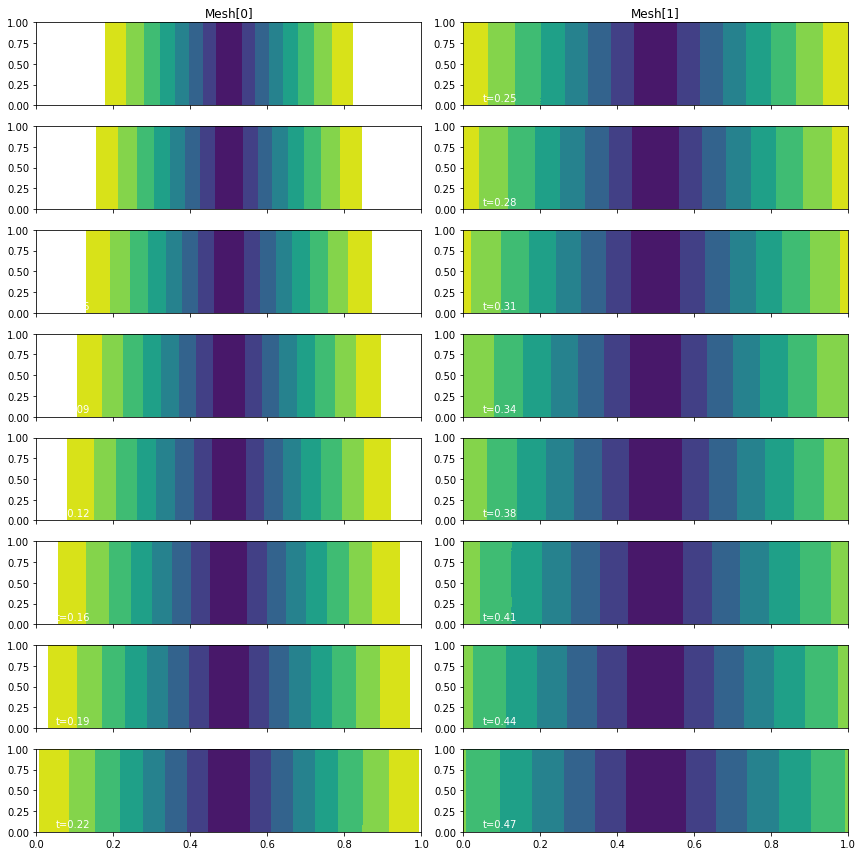

In [25]:
n = 32
fields = ["u"]
meshes = [
    UnitSquareMesh(n, n, diagonal="left"),
    UnitSquareMesh(n, n, diagonal="left"),
]
end_time = 0.5
dt = 1 / n
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions = mesh_seq.solve_forward()
fig, axes, tcs = plot_snapshots(solutions, time_partition, "u", "forward", levels=np.linspace(0, 0.8, 9))
# Note this is plotting the magnitude

In [26]:
solutions = mesh_seq.solve_adjoint()

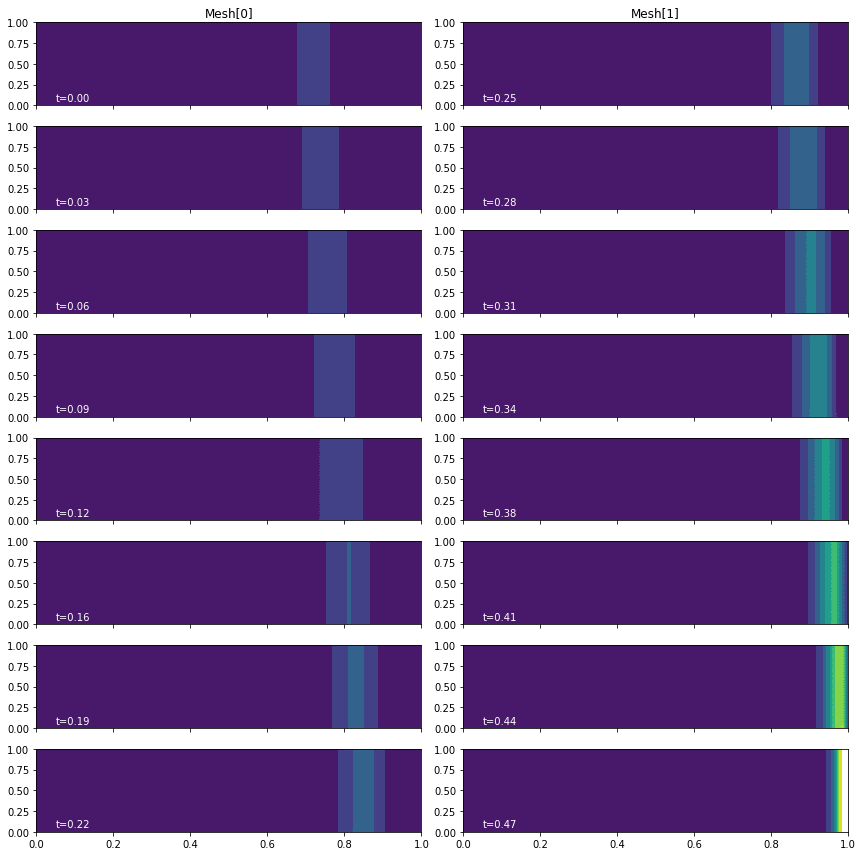

In [27]:
# print("QOI: {}".format(mesh_seq.get_qoi()))
fig, axes, tcs = plot_snapshots(
    solutions, time_partition, "u", "adjoint", levels=np.linspace(0, 0.8, 9)
)
fig.savefig("burgers2.jpg")

In [28]:
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

In [41]:
print(len(indicators[0]))
print(type(indicators))
print(len(indicators))
print(indicators[0][0].dat.data.shape)
print(mesh_seq[0].num_cells())
print(np.max(np.abs(indicators[0][7].dat.data)))

8
<class 'list'>
2
(2048,)
2048
7.941537930390896e-09


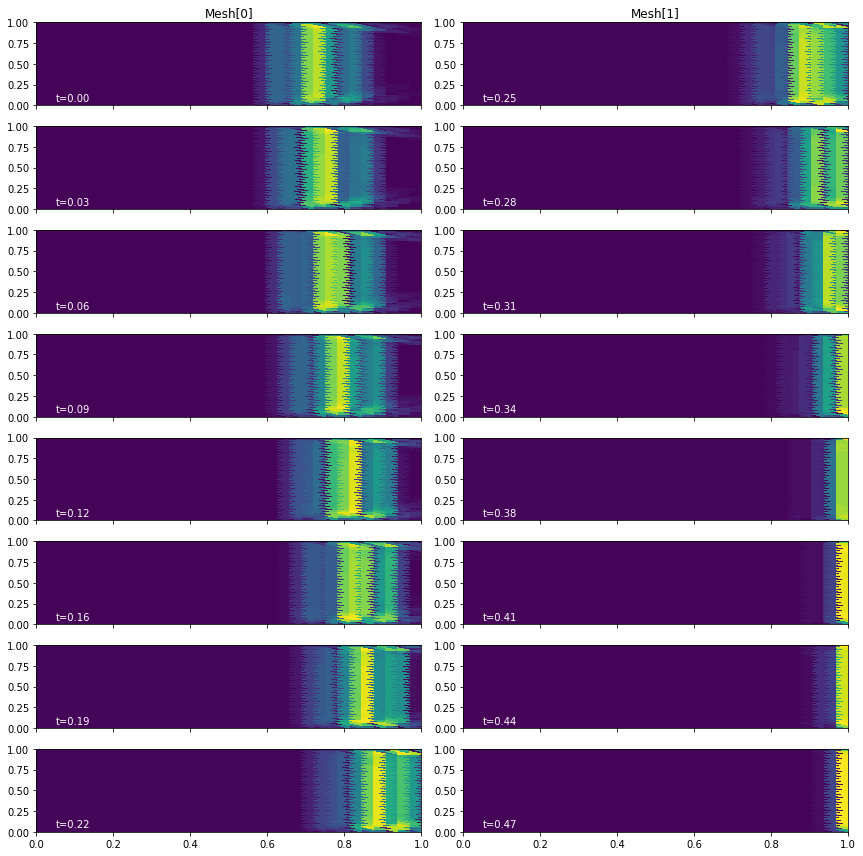

In [42]:
for field, sols in solutions.items():
    fwd_outfile = File(f"test_burgers2/{field}_forward.pvd")
    adj_outfile = File(f"test_burgers2/{field}_adjoint.pvd")
    for i, mesh in enumerate(mesh_seq):
        for sol in sols["forward"][i]:
            fwd_outfile.write(sol)
        for sol in sols["adjoint"][i]:
            adj_outfile.write(sol)

fig, axes, tcs = plot_indicator_snapshots(indicators, time_partition, levels=50)
fig.savefig("ee-adj.jpg")

## Error indicators to a monitor function to mesh adaptation

To create a scalar monitor function, we need 2 assumptions - 
1. The error indicators are a good approximation *
2. The local errors $\epsilon$ are proportional to the square of local grid-length parameter $l$, i.e. $\epsilon = c l^2$ for some scalar constant $c > 0$. 

* - don't think this IS a good assumption because our error is so low to begin with - might have to change something

We have verified that our indicators are essentially a P0 function, i.e. one that varies per cell. We need to then create this monitor function using some sort of regression / interpolation to solve for the best-fit value of $c$? Also, importantly, we probably have to smooth this function somewhat. The mesh can become really deformed and lose overall quality if we don't. 

In Bauer et al. [2014] they assume $\epsilon_{\text{est}} = c l^2_{\text{est}}$ where $l_{\text{est}}$ is the grid-length of the uniform un-adapted grid. In our problem we are trying to distribute the error globally across cells. By making errors across all cells even, we will be enforcing that the grid-length of cells in the more error-prone regions of the domain decreases as compared to those in regions that do not affect the QOI. Thus, we can pick some target error, and solve for $l^2_{\text{target}}$ in each cell to adapt it. So, an implementation can go cell-by-cell, and move the vertex-coordinates globally to achieve the target edge-length but probably shouldn't. I assume we can use a metric space also to do this. In keeping with ensuring good mesh quality we can use constraints as described in Bauer [2014] but we probably want to re-examine this. 


To actually achieve the r-adaptation, the paper describes a method that solves for the monitor function $f(x)$, such that $\int_{\Omega} f(x) dA(x) = 1$, with $c = C_{\text{norm}} > 0$ and ensuring that other constraints are met (e.g. grid duality constraint - centroids must lie inside the original cell). Now, we represent $f$ as a transformation of all the grid points' coordinates. Since $f$ represents a ratio of the new area of each element to the old area, it's essentially describing a determinant of some transformation of these grid points. Based on existing literature, if we have $f > 0$ in $\Omega$ and $\int_{\Omega} (f(x)-1)dA(x) = 0$, then this transformation exists and is given by 

$$\text{det} \nabla \phi (x, y) = f(x, y) \text{  in  } \Omega $$
and 
$$\phi (x, y) = (x, y)  \text { on } \Gamma = \partial \Omega$$

Once we've got to this point, there's a clever way to calculate $\phi$ as a system of ODEs